In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import seaborn as sns
from sklearn.decomposition import PCA
from ast import literal_eval
from collections import Counter
import gower
from sklearn.feature_selection import VarianceThreshold

In [7]:
user_profile = pd.read_csv("data/user_profile/prepared/User_Profile.csv")

In [8]:
user_profile.drop(["Unnamed: 0"],axis=1, inplace=True)

## Scaling Categorical Features

In [45]:
data = user_profile.iloc[:,[2,6,9,12,15,19,25,28,64,69,66,17,22,23,29,32,33,41,44,48,53,61,71,84,85,86,87,88,89,90,91,92,93,94,95]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   OFFNET_INCOMING_Scaled                2916 non-null   float64
 1   OFFNET_OUTGOING_Scaled                2809 non-null   float64
 2   ONNET_INCOMING_Scaled                 2833 non-null   float64
 3   ONNET_OUTGOING_Scaled                 2832 non-null   float64
 4   IDD_INCOMING_Scaled                   1445 non-null   float64
 5   IDD_OUTGOING_Scaled                   477 non-null    float64
 6   PEO_TV_Scaled                         1142 non-null   float64
 7   BB_Scaled                             1113 non-null   float64
 8   BB_Extra_GB_Purchased_Scaled          1394 non-null   float64
 9   Peo_Extra_Channels_Purchased_Scaled   47 non-null     float64
 10  BB_Extra_GB_Amount                    568 non-null    float64
 11  IDD_incoming_coun

### Filling null values 

#### Filling Usage Columns - with MEAN for particular Sub Type based Usage, else 0

In [46]:
data["Sub_Type"].value_counts()

TRIPLE_PLAY       2379
DOUBLE_PLAY_BV     246
SINGLE_PLAY        156
DOUBLE_PLAY_PV     134
4G                   1
Name: Sub_Type, dtype: int64

In [47]:
usage_cols = ["ONNET_OUTGOING_Scaled","ONNET_INCOMING_Scaled","OFFNET_OUTGOING_Scaled","OFFNET_INCOMING_Scaled","OFFNET_INCOMING_Scaled"]

In [48]:
for col in usage_cols:
    data[col] = np.where(data["Sub_Type"].isnull() == False & data[col].isnull(), data[col].fillna(data[col].mean()), data[col])

<ipython-input-48-cdc94c9275ff>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-cdc94c9275ff>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-cdc94c9275ff>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-48-cdc94c9

In [49]:
data["ONNET_OUTGOING_Scaled"].value_counts()

0.098412    84
0.001202    35
0.002772    21
0.001570    19
0.002404    18
            ..
0.172194     1
0.224343     1
0.049868     1
0.154705     1
0.047586     1
Name: ONNET_OUTGOING_Scaled, Length: 2106, dtype: int64

In [50]:
data["PEO_TV_Scaled"] = np.where(data["PEO_TV_Scaled"].isnull() & ((data["Sub_Type"]=="DOUBLE_PLAY_PV") | (data["Sub_Type"]=="TRIPLE_PLAY")), data["PEO_TV_Scaled"].fillna(data["PEO_TV_Scaled"].mean()), data["PEO_TV_Scaled"])

<ipython-input-50-4777164b7e7f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
data["PEO_TV_Scaled"].value_counts()

0.566988    1532
0.000000     194
0.950000     159
0.712500      67
0.918750      51
            ... 
0.750000       1
0.456250       1
0.131250       1
0.425000       1
0.756250       1
Name: PEO_TV_Scaled, Length: 123, dtype: int64

In [52]:
data["BB_Scaled"] = np.where(data["BB_Scaled"].isnull() & ((data["Sub_Type"]=="DOUBLE_PLAY_BV") | (data["Sub_Type"]=="TRIPLE_PLAY")), data["BB_Scaled"].fillna(data["BB_Scaled"].mean()), data["BB_Scaled"])

<ipython-input-52-e8be941d476f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
data["BB_Scaled"].value_counts()

0.366040    1513
0.064236      16
0.916667      12
0.072917      11
1.000000      11
            ... 
0.388889       1
0.699653       1
0.713542       1
0.572917       1
0.581597       1
Name: BB_Scaled, Length: 355, dtype: int64

In [54]:
scaled_cols = ["PEO_TV_Scaled","BB_Scaled","BB_Extra_GB_Purchased_Scaled","BB_Extra_GB_Amount","Peo_Extra_Channels_Purchased_Scaled","IDD_INCOMING_Scaled","IDD_OUTGOING_Scaled"]
data[scaled_cols] = data[scaled_cols].fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
cat_cols = ["IDD_incoming_country","IDD_outgoing_country","GENDER","Peo_TV_Package","VAS_Package","Megaline_Package","BB_Package","Package_Type","Sub_Update","Having_Insurance","Tamil_Customer"]
data[cat_cols] = data[cat_cols].fillna("NO_INFO")

In [56]:
data.isnull().sum()

OFFNET_INCOMING_Scaled                  0
OFFNET_OUTGOING_Scaled                  0
ONNET_INCOMING_Scaled                   0
ONNET_OUTGOING_Scaled                   0
IDD_INCOMING_Scaled                     0
IDD_OUTGOING_Scaled                     0
PEO_TV_Scaled                           0
BB_Scaled                               0
BB_Extra_GB_Purchased_Scaled            0
Peo_Extra_Channels_Purchased_Scaled     0
BB_Extra_GB_Amount                      0
IDD_incoming_country                    0
IDD_outgoing_country                    0
Peo_TV_Package                          0
BB_Package                              0
Location_Identifier                     0
GENDER                                  0
Sub_Type                                0
Megaline_Package                        0
Package_Type                            0
VAS_Package                             0
Sub_Update                              0
Having_Insurance                        0
Tamil_Customer                    

In [57]:
#data_cat = data.iloc[:,9:25]

In [58]:
data.describe()

,OFFNET_INCOMING_Scaled,OFFNET_OUTGOING_Scaled,ONNET_INCOMING_Scaled,ONNET_OUTGOING_Scaled,IDD_INCOMING_Scaled,IDD_OUTGOING_Scaled,PEO_TV_Scaled,BB_Scaled,BB_Extra_GB_Purchased_Scaled,Peo_Extra_Channels_Purchased_Scaled,...,Peo_Packages_if_Kids,Peo_Packages_if_Teenager_Students,Peo_Package_if_Working_Professionals,BB_Package_if_Working_Professionals,BB_Packages_if_Teenager_Students,BB_Packages_if_SMEss,VAS_if_Kids,VAS_if_Teenager_Students,VAS_if_Working_Professionals,IDD_if_Family_Member_Abroad
count,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,...,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000,2916.000000
mean,0.107654,0.106838,0.098611,0.098412,0.045928,0.015838,0.519933,0.329637,0.005691,0.003560,...,0.000549,0.001509,0.003567,0.001303,0.002195,0.000617,0.008985,0.042387,0.035751,0.022119
std,0.095940,0.106013,0.099157,0.096614,0.123396,0.068826,0.261278,0.195798,0.014725,0.035238,...,0.010463,0.017309,0.026473,0.016094,0.020840,0.011096,0.068816,0.117902,0.097059,0.191320
min,0.001202,0.001202,0.001202,0.001202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.028470,0.028012,0.020604,0.022383,0.000000,0.000000,0.566988,0.232639,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.087528,0.080799,0.068595,0.069994,0.000000,0.000000,0.566988,0.366040,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.161033,0.147542,0.147708,0.149517,0.020000,0.000000,0.566988,0.366040,0.010000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.948718,1.000000,1.000000,1.000000,0.882000,0.833333,0.975000,1.000000,0.360515,1.000000,...,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,1.000000,0.800000,0.750000,2.500000


### Correlations

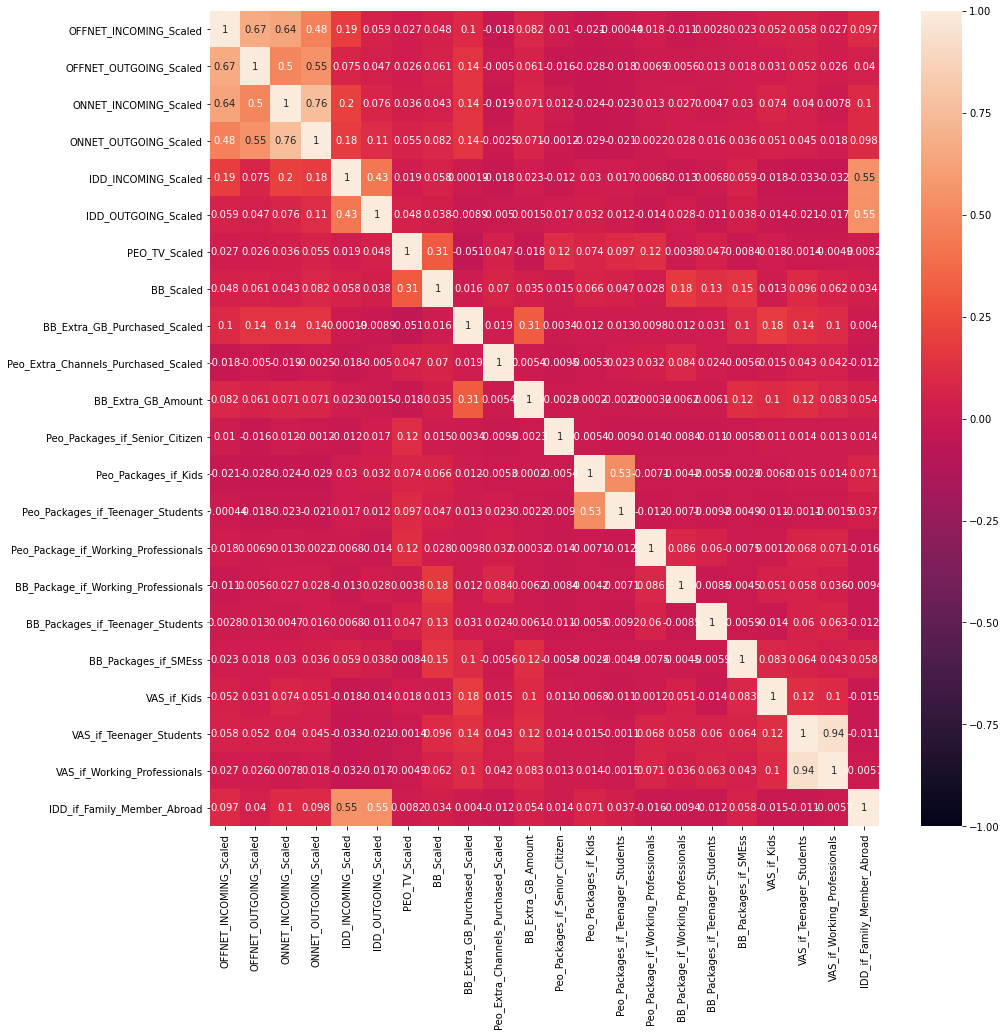

In [59]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,vmin=-1,vmax=1)
plt.show()

## Measuring Distances of Categorical Variables with Gower 

In [61]:
mp = [False for i in range (0,11)]+[True for j in range (0,13)]+[False for i in range (0,11)]

In [62]:
len(mp)

35

In [63]:
dm = gower.gower_matrix(data, cat_features = mp )

## Feature Selection

- Feature selector that removes all low-variance features.
- This feature selection algorithm looks only at the features (X), not the desired outputs (y), and can thus be used for unsupervised learning.
- docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [64]:
selector = VarianceThreshold()

In [65]:
selected_matrix = selector.fit_transform(dm)

In [66]:
dm.shape

(2916, 2916)

In [67]:
selected_matrix.shape

(2916, 2916)

# Applying PCA

### Find most approporiate no of components

In [71]:
pc=PCA(n_components=35) 
pc.fit(dm)

PCA(n_components=35)

In [98]:
#How much variance,caputured individually
pc.explained_variance_

array([5.87321377e+00, 7.50180244e-01, 5.49693108e-01, 3.94134760e-01,
       3.20796162e-01, 2.70749748e-01, 2.39148214e-01, 1.30660698e-01,
       1.14257626e-01, 9.87534076e-02, 5.79009131e-02, 5.26299439e-02,
       4.81264964e-02, 4.15796489e-02, 3.98670137e-02, 3.07370648e-02,
       2.66454201e-02, 2.21475754e-02, 2.11059190e-02, 1.87223312e-02,
       1.67673379e-02, 1.51304975e-02, 1.29710371e-02, 1.16672982e-02,
       1.08741997e-02, 9.07612219e-03, 8.43640231e-03, 7.75331119e-03,
       7.41983205e-03, 7.05240481e-03, 6.57755183e-03, 6.34767348e-03,
       6.06244663e-03, 5.57028502e-03, 5.33351209e-03], dtype=float32)

In [106]:
#How mucb variance, captured together
cumsum_arr = pc.explained_variance_ratio_.cumsum() 

In [107]:
cumsum_arr

array([0.6275617 , 0.70771956, 0.7664551 , 0.808569  , 0.8428466 ,
       0.8717766 , 0.8973299 , 0.91129124, 0.9234998 , 0.93405175,
       0.94023854, 0.9458621 , 0.9510045 , 0.9554474 , 0.9597072 ,
       0.9629915 , 0.96583855, 0.96820503, 0.97046024, 0.97246075,
       0.97425234, 0.97586906, 0.97725505, 0.97850174, 0.97966367,
       0.98063344, 0.9815349 , 0.98236334, 0.98315614, 0.9839097 ,
       0.9846125 , 0.98529077, 0.98593855, 0.98653376, 0.98710364],
      dtype=float32)

In [108]:
pca_df = pd.DataFrame(data.columns.tolist(),columns=["Feature"])

In [109]:
pca_df["Importance"] = cumsum_arr

In [110]:
pca_df

,Feature,Importance
0,OFFNET_INCOMING_Scaled,0.627562
1,OFFNET_OUTGOING_Scaled,0.707720
2,ONNET_INCOMING_Scaled,0.766455
3,ONNET_OUTGOING_Scaled,0.808569
4,IDD_INCOMING_Scaled,0.842847
5,IDD_OUTGOING_Scaled,0.871777
6,PEO_TV_Scaled,0.897330
7,BB_Scaled,0.911291
8,BB_Extra_GB_Purchased_Scaled,0.923500
9,Peo_Extra_Channels_Purchased_Scaled,0.934052


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



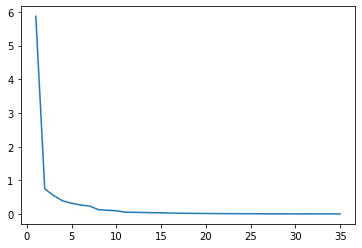

In [111]:
sns.lineplot(range(1,1+pc.explained_variance_.shape[0]),pc.explained_variance_)
plt.show()

In [112]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca_2d = PCA(n_components=2)
pca_2d.fit(dm)
reduced_data = pca_2d.fit_transform(dm)
results_2d_df = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

# applying min-max-scaler to reduced features
scaler = MinMaxScaler()
results_2d_df[['pca1','pca2']] = scaler.fit_transform(results_2d_df[['pca1','pca2']])

results = results_2d_df.values

In [113]:
### Run PCA on the data and reduce the dimensions in pca_num_components dimensions
pca_3d = PCA(n_components=3)
pca_3d.fit(dm)
reduced_data = pca_3d.fit_transform(dm)
results_3d_df = pd.DataFrame(reduced_data,columns=['pca1','pca2','pca3'])

# applying min-max-scaler to reduced features
scaler = MinMaxScaler()
results_3d_df[['pca1','pca2','pca3']] = scaler.fit_transform(results_3d_df[['pca1','pca2','pca3']])

results_3d = results_3d_df.values

# Clustering

## Hierarchical f Clusters and Dendrogram
- Hierarchical Clustering

## Ward Linkage

In [114]:
result = linkage(dm, method="ward") 

<ipython-input-114-9e9835db30c2>:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



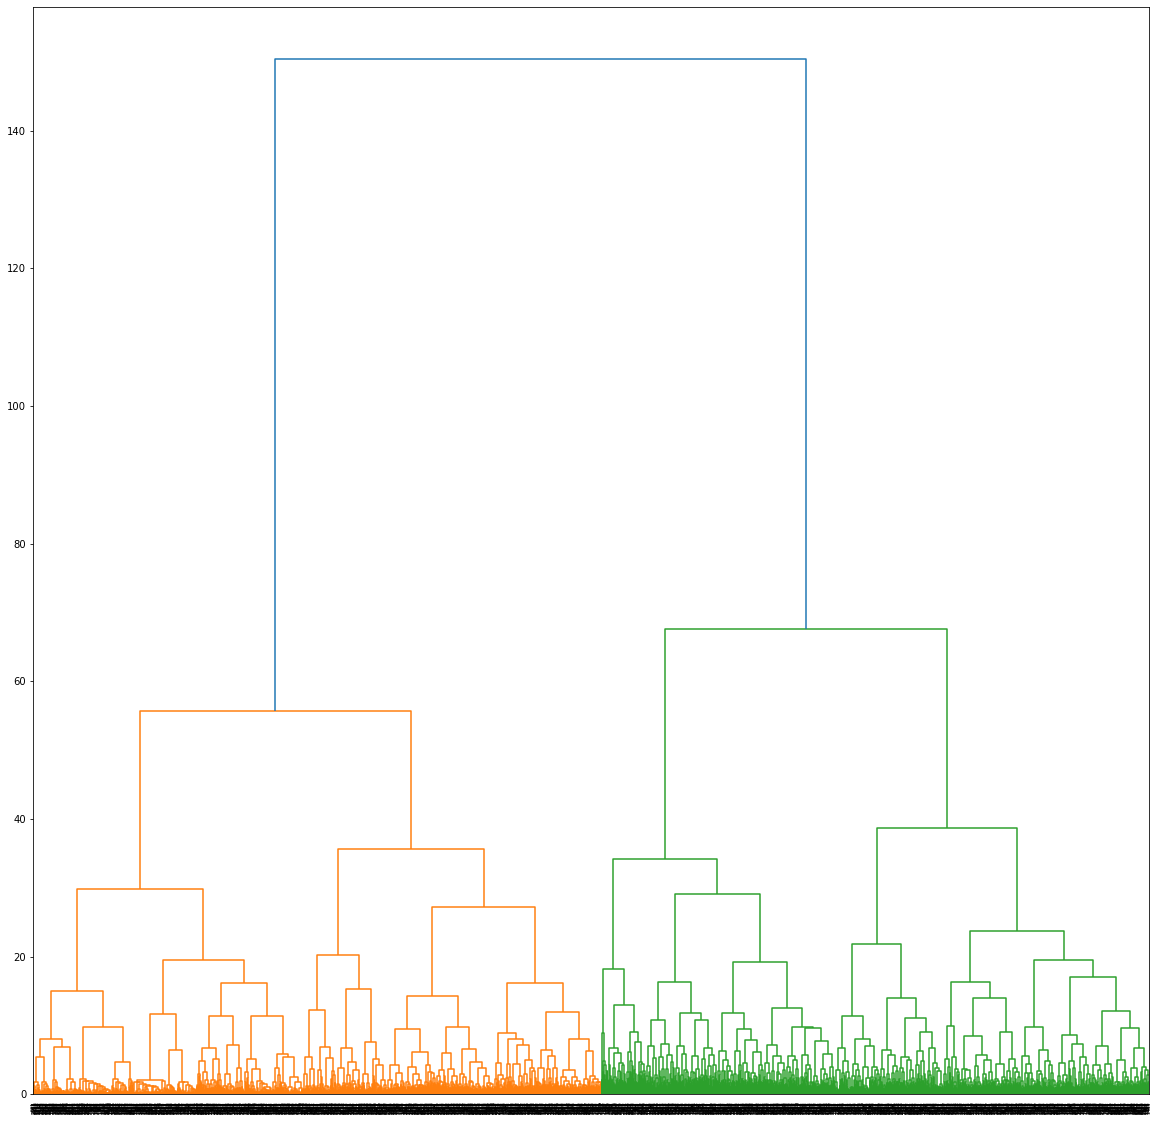

In [115]:
plt.figure(figsize=(20,20))
shc.dendrogram(result)
plt.show()

## Avarage Linkage

<ipython-input-116-01c5b7495027>:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



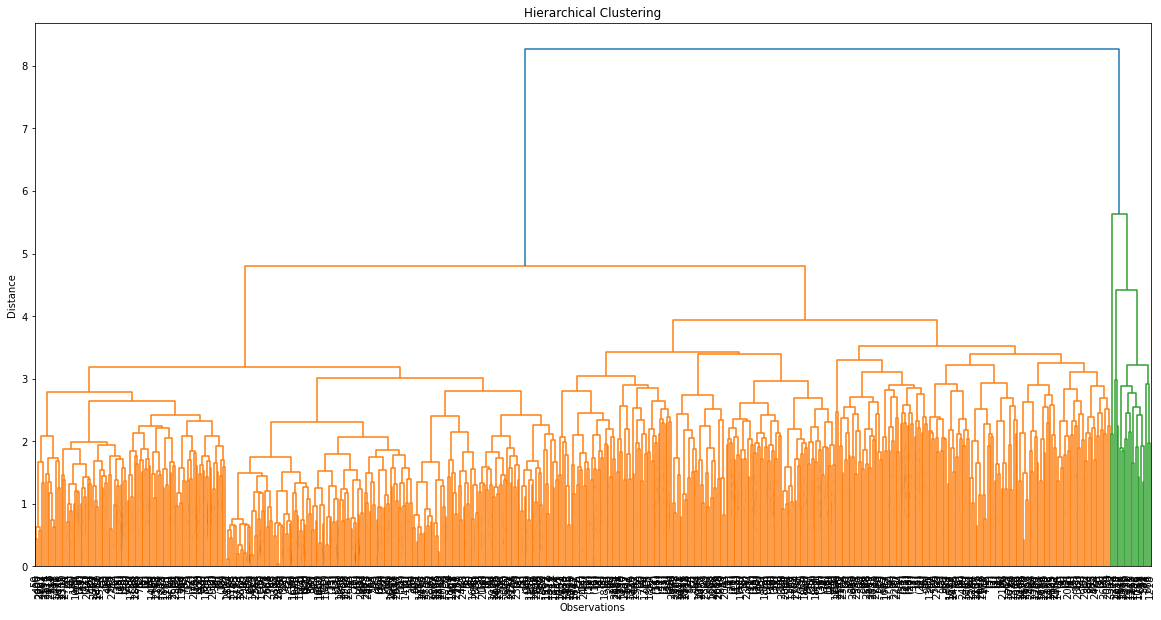

In [116]:
hc_average = linkage(dm, "average")

plt.figure(figsize=(20, 10))
plt.title("Hierarchical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average,
           leaf_font_size=10, 
           p=10,
           show_contracted=True,
          truncate_mode='level')
plt.show()

## Complete Linkage

<ipython-input-117-cd4585891250>:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



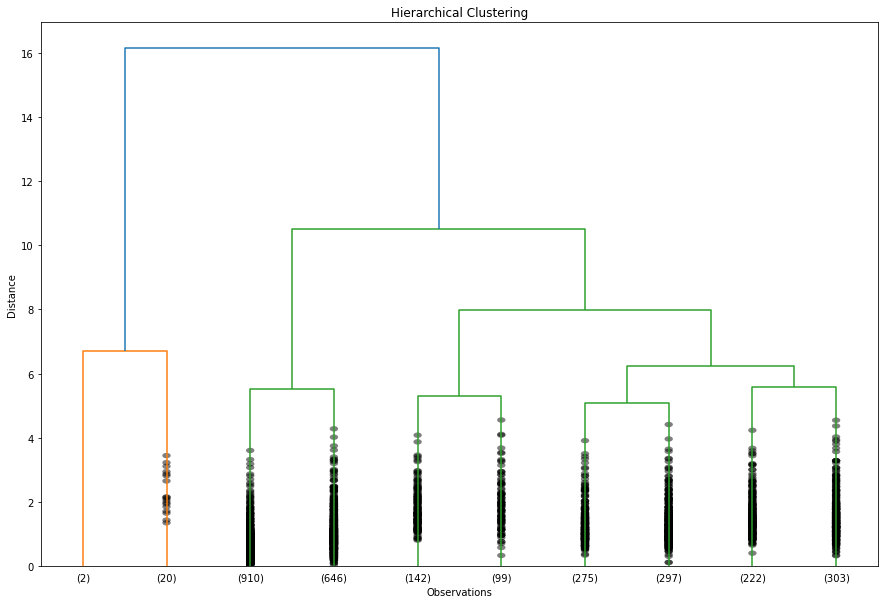

In [117]:
# Complete Linkage Method
hc_complete = linkage(dm, "complete")

plt.figure(figsize=(15, 10))
plt.title("Hierarchical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

## F clusters

In [154]:
ag_y_clusters = fcluster(result, 4, criterion='maxclust')
ag_y_clusters

array([1, 1, 4, ..., 4, 2, 2], dtype=int32)

In [155]:
cluster_labels=["x",0,1,2,3]
val_dict = dict(zip(cluster_labels,np.bincount(ag_y_clusters)))
val_dict.pop("x")
val_dict

{0: 705, 1: 780, 2: 609, 3: 822}

In [156]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Pca 1'),yaxis = dict(title  = 'Pca 2'),zaxis = dict(title  = 'Pca 3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = ag_y_clusters
trace = go.Scatter3d(x=results_3d[:, 0], y=results_3d[:, 1], z=results_3d[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width =1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# Agglomerative Clustering - 4 Clusters (ward)

In [148]:
acl=AgglomerativeClustering(n_clusters=4,affinity="euclidean",linkage="ward")

In [149]:
acl.fit(dm)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



AgglomerativeClustering(n_clusters=4)

In [150]:
# cluster labels
acl_y_clusters = acl.labels_

In [151]:
acl_y_clusters

array([3, 3, 0, ..., 0, 1, 1], dtype=int64)

In [152]:
cluster_labels=[0,1,2,3]
dict(zip(cluster_labels,np.bincount(acl_y_clusters)))

{0: 822, 1: 780, 2: 609, 3: 705}

In [153]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Pca 1'),yaxis = dict(title  = 'Pca 2'),zaxis = dict(title  = 'Pca 3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = acl_y_clusters
trace = go.Scatter3d(x=results_3d[:, 0], y=results_3d[:, 1], z=results_3d[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width =1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

# K-Means Clustering

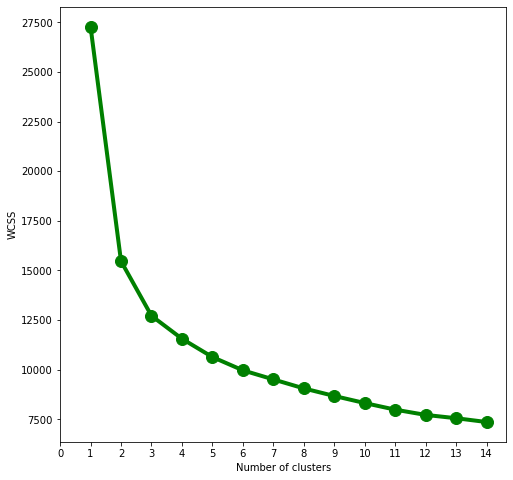

In [133]:
# find the optimal number of clusters using elbow method
WCSS = []
for i in range(1,15):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(dm)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (8,8))
plt.plot(range(1,15),WCSS, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(15))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [134]:
# since elbow occured at 3, let's consider 3 clusters
km_model = KMeans(n_clusters = 3, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
kmeans_y_clusters = km_model.fit_predict(dm)

In [135]:
kmeans_y_clusters

array([0, 0, 2, ..., 2, 0, 0])

In [136]:
km_model.labels_

array([0, 0, 2, ..., 2, 0, 0])

In [137]:
cluster_labels=[0,1,2]
dict(zip(cluster_labels,np.bincount(km_model.labels_)))

{0: 1167, 1: 643, 2: 1106}

In [138]:
km_model.cluster_centers_

array([[0.11935328, 0.15456721, 0.18118806, ..., 0.21401578, 0.1755456 ,
        0.14403036],
       [0.27511698, 0.28778705, 0.31625953, ..., 0.29605377, 0.31336278,
        0.27234796],
       [0.19860359, 0.22999276, 0.24786748, ..., 0.23719275, 0.2551485 ,
        0.2013709 ]], dtype=float32)

# K-Medoids Clustering

In [139]:
#Reference : https://stackoverflow.com/questions/66441887/how-can-i-implement-pam-clustering-algorithm-using-gower-distance-in-sklearn
#https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html
kmedoids = KMedoids(n_clusters=3, random_state=0,metric = 'precomputed', method = 'pam', init =  'k-medoids++')

In [140]:
kmod_y_clusters = kmedoids.fit_predict(dm)

In [141]:
kmod_y_clusters

array([1, 0, 0, ..., 2, 0, 0], dtype=int64)

In [142]:
kmedoids.labels_

array([1, 0, 0, ..., 2, 0, 0], dtype=int64)

In [143]:
print(kmedoids.cluster_centers_)

None


In [144]:
cluster_labels=[0,1,2]
dict(zip(cluster_labels,np.bincount(kmedoids.labels_)))

{0: 1231, 1: 931, 2: 754}

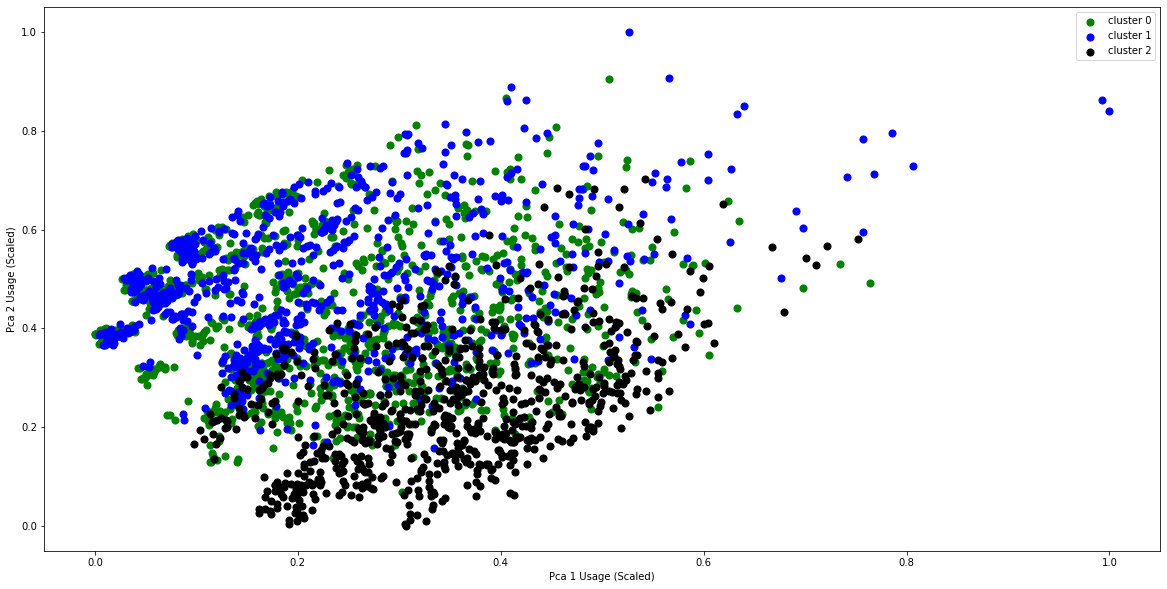

In [145]:
plt.figure(figsize = (20,10))
plt.scatter(results[kmod_y_clusters == 0,0],results[kmod_y_clusters == 0,1],s = 50, c = 'green', label = "cluster 0")
plt.scatter(results[kmod_y_clusters == 1,0],results[kmod_y_clusters == 1,1],s = 50, c = 'blue', label = "cluster 1")
plt.scatter(results[kmod_y_clusters == 2,0],results[kmod_y_clusters == 2,1],s = 50, c = 'black', label = "cluster 2")
#plt.scatter(results[y_clusters == 3,0],results[y_clusters == 3,1],s = 50, c = 'red', label = "cluster 3")
#plt.scatter(kmedoids.cluster_centers_[:,0],kmedoids.cluster_centers_[:,1], s = 100, c = "yellow", label = "centroids")
plt.xlabel("Pca 1 Usage (Scaled)")
plt.ylabel("Pca 2 Usage (Scaled)")
plt.legend()
plt.show()

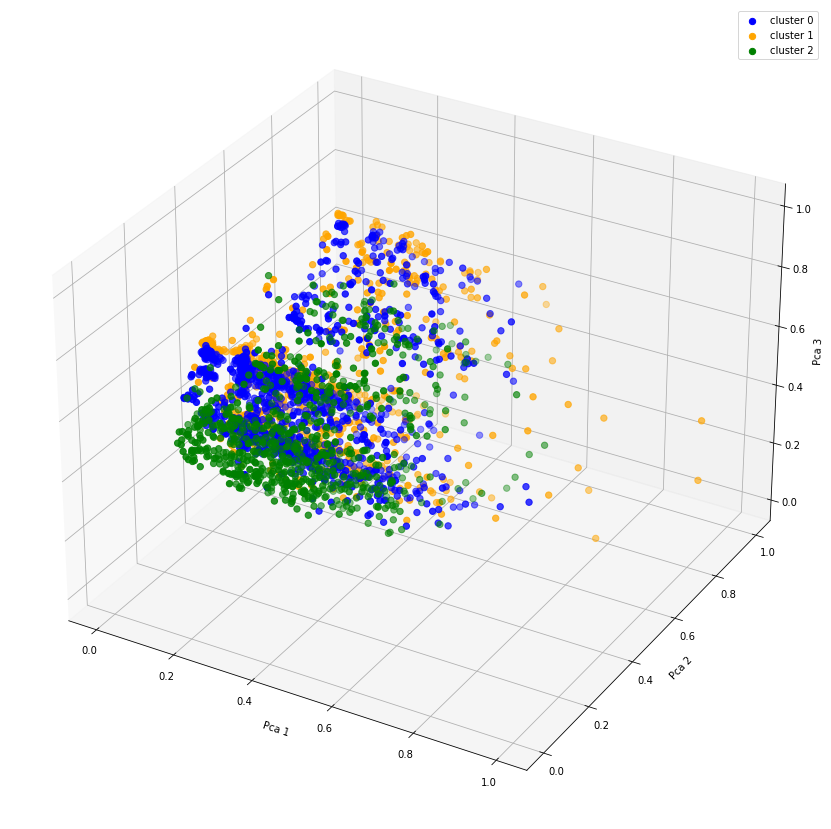

In [146]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results_3d[kmod_y_clusters == 0,0],results_3d[kmod_y_clusters == 0,1],results_3d[kmod_y_clusters == 0,2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(results_3d[kmod_y_clusters == 1,0],results_3d[kmod_y_clusters == 1,1],results_3d[kmod_y_clusters == 1,2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(results_3d[kmod_y_clusters == 2,0],results_3d[kmod_y_clusters == 2,1],results_3d[kmod_y_clusters == 2,2], s = 40 , color = 'green', label = "cluster 2")
#ax.scatter(results_3d[y_clusters == 3,0],results_3d[y_clusters == 3,1],results_3d[y_clusters == 3,2], s = 40 , color = 'red', label = "cluster 2")
ax.set_xlabel('Pca 1')
ax.set_ylabel('Pca 2')
ax.set_zlabel('Pca 3')
ax.legend()
plt.show()

In [147]:
# 3d scatterplot using plotly
Scene = dict(xaxis = dict(title  = 'Pca 1'),yaxis = dict(title  = 'Pca 2'),zaxis = dict(title  = 'Pca 3'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = kmedoids.labels_
trace = go.Scatter3d(x=results_3d[:, 0], y=results_3d[:, 1], z=results_3d[:, 2], mode='markers',marker=dict(color = labels, size= 5, line=dict(color= 'black',width =1)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

## Adding clusters column to existing user profile

In [157]:
user_profile["KMOD_3_Cluster"] = kmod_y_clusters

In [158]:
user_profile["H_max_4_Cluster"] = ag_y_clusters

In [159]:
user_profile["H_Agg_4_Cluster"] = acl_y_clusters

In [160]:
user_profile.to_csv("data/user_profile/prepared/User_Profile_Socio_features_with_clusters.csv")